# Movie Recommender System
The short script aims to practice working with Movie Recommender System using Collaborative Filtering (Item-based and KNN)

###  Memory-Based Methods:
* User-Based: Takes a particular user, find users that are similar to that user based on similarity of ratings and recommend items that those similar users liked. “Users who are similar to you also liked …” 
* Item-Based: Take an item, find users who liked that item and find other items that those users or similar users also liked. “Users who liked this item also liked …”

In order to measure similarity, we want to find the correlation between two users/items. There were two similarity measurements we used. The first was the Pearson correlation coefficient and the other similarity measurement is called vector similarity.

### Model-Based Approach:
* K-Nearest Neighbor (KNN): Calculate the distance between the target movie and every other movie in its database then it ranks the top k nearest neighbor movies based on the distance.

For more Model-Based: https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0

#### Sources / Code Adapted From:
* http://www.cs.carleton.edu/cs_comps/0607/recommend/recommender/memorybased.html
* https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0
* https://analyticsindiamag.com/how-to-build-your-first-recommender-system-using-python-movielens-dataset/
* https://stackabuse.com/creating-a-simple-recommender-system-in-python-using-pandas/
* https://heartbeat.fritz.ai/recommender-systems-with-python-part-ii-collaborative-filtering-k-nearest-neighbors-algorithm-c8dcd5fd89b2
* https://www.aurigait.com/recommendation-system-using-knn/

## Step 1: Setup

In [1]:
# Imports
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Step 2: Load the Data
This notebook uses the MovieLens 1M dataset: https://grouplens.org/datasets/movielens/

In [2]:
# Make display smaller
pd.options.display.max_rows = 10

ratingNames = ['user_id', 'movie_id', 'rating']
ratings = pd.read_csv('data/movielens/ratings.dat', sep='::', header=None, names=ratingNames, engine='python', usecols=range(3),
                     dtype={'user_id': 'int32', 'movie_id': 'int32', 'rating': 'float32'})

moviesNames = ['movie_id', 'title', 'genres']
movies = pd.read_csv('data/movielens/movies.dat', sep='::',header=None, names=moviesNames, engine='python',
                     dtype={'movie_id': 'int32', 'title': 'str', 'genre':'str'})

In [3]:
ratings.head()

,user_id,movie_id,rating
0,1,1193,5.0
1,1,661,3.0
2,1,914,3.0
3,1,3408,4.0
4,1,2355,5.0


In [4]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## Step 3: Explore & Visualize the Data

In [5]:
# Compute the number of unique users and movies
uniqueUsers = len(ratings.user_id.unique())
uniqueMovies = len(movies.movie_id.unique())
print('There are %s unique users and %s unique movies in the data set' % (uniqueUsers, uniqueMovies))

There are 6040 unique users and 3883 unique movies in the data set


#### Compute Ratings Properties and Visualize

In [6]:
# Compute the count for each of the ratings
ratingCounts = pd.DataFrame(ratings.groupby('rating').size(), columns=['count']).reset_index()
ratingCounts

,rating,count
0,1.0,56174
1,2.0,107557
2,3.0,261197
3,4.0,348971
4,5.0,226310


In [7]:
# Figure out the NaN rating for the movies (where there is no rating of a specific movie by a specific user)
ratingTotalCounts = uniqueUsers * uniqueMovies
noRatingCounts = ratingTotalCounts - ratings.shape[0]
print("Number of no ratings for the movies", noRatingCounts)

Number of no ratings for the movies 22453111


In [8]:
# Adding the number of no rating for our dataframe
fullRatingCounts = ratingCounts.append(pd.DataFrame({'rating':"NaN", 'count': noRatingCounts},index=[-1])).sort_index()
fullRatingCounts

,rating,count
-1,NaN,22453111
0,1,56174
1,2,107557
2,3,261197
3,4,348971
4,5,226310


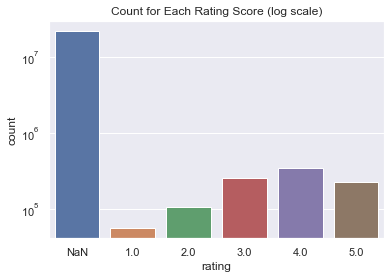

In [9]:
# Ploting the Count for each rating score (log scale)
ax = sns.barplot(x="rating", y="count", data=fullRatingCounts)
ax.set_title('Count for Each Rating Score (log scale)');
ax.set_yscale("log")

# From the plot, one can see that the data set is very sparse (not every movie get rated by every user)
# which make sense since there are so many movies and there is no way the users watched all of them

#### Compute Movies Properties and Visualize

In [10]:
# Merge the movies and ratings Dataframe
movies_ratings = pd.merge(movies, ratings, on='movie_id')
movies_ratings.head()

,movie_id,title,genres,user_id,rating
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5.0
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4.0
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4.0
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5.0
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5.0


In [11]:
# Calculate the mean and size/count of the ratings
moviesProperties = movies_ratings.groupby('title').agg({'rating': [np.mean, np.size]}).rename(columns={'mean': 'avgRating',
                                                                                                       'size':'totalRating'})
moviesProperties.head(10)

rating            
                                  avgRating totalRating
title                                                  
$1,000,000 Duck (1971)             3.027027        37.0
'Night Mother (1986)               3.371428        70.0
'Til There Was You (1997)          2.692308        52.0
'burbs, The (1989)                 2.910891       303.0
...And Justice for All (1979)      3.713568       199.0
1-900 (1994)                       2.500000         2.0
10 Things I Hate About You (1999)  3.422857       700.0
101 Dalmatians (1961)              3.596460       565.0
101 Dalmatians (1996)              3.046703       364.0
12 Angry Men (1957)                4.295455       616.0

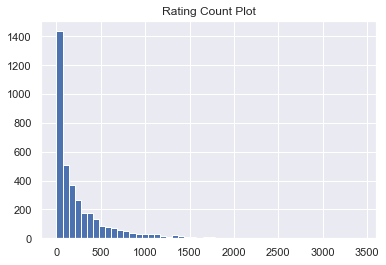

In [12]:
# Plot the size/count
moviesProperties['rating']['totalRating'].hist(bins=50)
plt.title("Rating Count Plot")
plt.show()

# Based on the plot, most user have less than 50 ratings

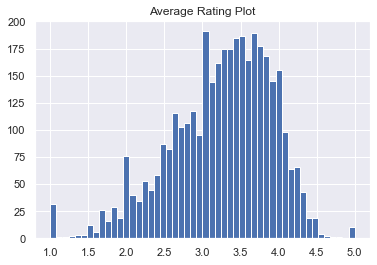

In [13]:
# Plot the average ratings
moviesProperties['rating']['avgRating'].hist(bins=50)
plt.title("Average Rating Plot")
plt.show()

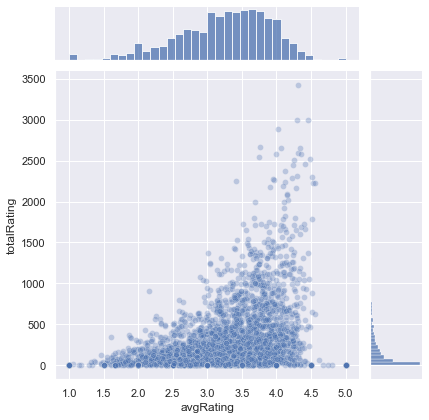

In [14]:
# Use jointplot to plot both the scatterplot and histograms
sns.jointplot(x='avgRating', y='totalRating', data=moviesProperties['rating'], alpha=0.3)
plt.show()

## Step 4: Preprocessing the Data

#### Adding a Fake User Ratings
To evaluate the movies recomemdation later on

In [15]:
comedy = movies[movies["genres"] == "Comedy"]
comedy.head(10)

,movie_id,title,genres
4,5,Father of the Bride Part II (1995),Comedy
18,19,Ace Ventura: When Nature Calls (1995),Comedy
37,38,It Takes Two (1995),Comedy
51,52,Mighty Aphrodite (1995),Comedy
62,63,Don't Be a Menace to South Central While Drink...,Comedy
64,65,Bio-Dome (1996),Comedy
68,69,Friday (1995),Comedy
87,88,Black Sheep (1996),Comedy
94,96,In the Bleak Midwinter (1995),Comedy
99,101,Bottle Rocket (1996),Comedy


In [16]:
thriller_action = movies[(movies["genres"] == "Thriller") | (movies["genres"] == "Action")]
thriller_action.head(10)

,movie_id,title,genres
8,9,Sudden Death (1995),Action
17,18,Four Rooms (1995),Thriller
19,20,Money Train (1995),Action
22,23,Assassins (1995),Thriller
70,71,Fair Game (1995),Action
101,103,Unforgettable (1996),Thriller
130,132,Jade (1995),Thriller
143,145,Bad Boys (1995),Action
181,183,Mute Witness (1994),Thriller
188,190,Safe (1995),Thriller


In [17]:
fake_user = pd.DataFrame([[0, 20, 5], [0, 23, 4], [0, 69, 2], [0, 88, 1]],
                          columns=['user_id', 'movie_id', 'rating'])

# This fake user loves Action/Thriller but hates Comedy
fakeUser_movies= pd.merge(movies, fake_user, on='movie_id')
fakeUser_movies

,movie_id,title,genres,user_id,rating
0,20,Money Train (1995),Action,0,5
1,23,Assassins (1995),Thriller,0,4
2,69,Friday (1995),Comedy,0,2
3,88,Black Sheep (1996),Comedy,0,1


In [18]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html

# Add the fake user into our dataset
ratings = pd.concat([ratings, fake_user]).reset_index(drop=True)
ratings.tail(5)

,user_id,movie_id,rating
1000208,6040,1097,4.0
1000209,0,20,5.0
1000210,0,23,4.0
1000211,0,69,2.0
1000212,0,88,1.0


In [19]:
# Merge the dataset again, this time with our fake user
movies_ratings_full = pd.merge(movies, ratings, on='movie_id')
movies_ratings_full.head()

,movie_id,title,genres,user_id,rating
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5.0
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4.0
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4.0
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5.0
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5.0


## Step 5: Memory-based approach: Item Based Collaborative Filtering

In [20]:
# Creating a table for Item-based Collborative Filtering: Rating of the users on every movies
# Note: Since we are working on Item-Based, we will focus on the similarity between the movies (columns)

userRatings = movies_ratings_full.pivot_table(index=['user_id'],columns=['title'],values='rating')
userRatings.head(10)

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


#### For User with only One Rating

In [21]:
# There is a RunTimeWarning when using the corrwith() method so use this to ignore it 
import warnings
warnings.filterwarnings('ignore')

# A sample movie to Compute pairwise correlation
sampleMovie = 'Toy Story (1995)'

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corrwith.html
singleCorrelation = userRatings.corrwith(userRatings[sampleMovie])
singleCorrelation.head()

title
$1,000,000 Duck (1971)          -0.132004
'Night Mother (1986)             0.261793
'Til There Was You (1997)        0.156468
'burbs, The (1989)              -0.077789
...And Justice for All (1979)    0.040958
dtype: float64

In [22]:
# Create a new Data frame so we can join it to get the total number of ratings, drop all the NaN values
singleRec = pd.DataFrame(singleCorrelation, columns=['correlation'])
singleRec.dropna(inplace=True)

singleRec = singleRec.join(moviesProperties['rating']['totalRating'])
singleRec.head()

,correlation,totalRating
title,,
"$1,000,000 Duck (1971)",-0.132004,37.0
'Night Mother (1986),0.261793,70.0
'Til There Was You (1997),0.156468,52.0
"'burbs, The (1989)",-0.077789,303.0
...And Justice for All (1979),0.040958,199.0


#### The recommendation is very good since the sample movie is 'Toy Story (1995)' and it recommended a lot of Animation/Children's genre movies

In [23]:
# Give the top 10 recommendations where the recommended movies have at least 100 ratings
recommendation = singleRec[singleRec['totalRating'] > 100].sort_values('correlation', ascending=False).reset_index()
recommendation = recommendation.merge(movies, on='title', how='left')
recommendation.head(10)

,title,correlation,totalRating,movie_id,genres
0,Toy Story (1995),1.000000,2077.0,1,Animation|Children's|Comedy
1,Toy Story 2 (1999),0.630386,1585.0,3114,Animation|Children's|Comedy
2,Ninotchka (1939),0.481678,132.0,936,Comedy|Romance
3,My Man Godfrey (1936),0.469717,188.0,947,Comedy
4,Air Bud (1997),0.467352,112.0,1592,Children's|Comedy
5,"Bug's Life, A (1998)",0.449198,1703.0,2355,Animation|Children's|Comedy
6,Oliver & Company (1988),0.446338,144.0,709,Animation|Children's
7,Cat Ballou (1965),0.431762,280.0,3873,Comedy|Western
8,Aladdin (1992),0.429626,1351.0,588,Animation|Children's|Comedy|Musical
9,"Raisin in the Sun, A (1961)",0.426576,143.0,3350,Drama


####  For User with Many Ratings

In [24]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

# User pandas corr() method to compute pairwise correlation of columns (excluding NA/null values)
# The Method of correlation is pearson and only keep results that have at least 100 ratings
correlationMatrix = userRatings.corr(method='pearson', min_periods=100)
correlationMatrix.head(10)

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Night Mother (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"'burbs, The (1989)",NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.088541,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...And Justice for All (1979),NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 Things I Hate About You (1999),NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.163892,0.372055,0.101730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022365
101 Dalmatians (1961),NaN,NaN,NaN,0.088541,NaN,NaN,0.163892,1.000000,0.479264,0.271421,...,NaN,0.013905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,NaN,NaN,NaN,NaN,0.372055,0.479264,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Get the fake user rating we created earlier in Step 3
fakeUserRatings = userRatings.loc[0].dropna()
fakeUserRatings

title
Assassins (1995)      4.0
Black Sheep (1996)    1.0
Friday (1995)         2.0
Money Train (1995)    5.0
Name: 0, dtype: float64

In [26]:
def collaborative_filtering(userRatings, corrMatrix):
    similarMovies = pd.Series()
    
    # 3 is an average rating = does not have multiplier
    # 1 and 2 is below average = negative penalty
    # 4 and 5 is above average = gain multiplier
    ratingMultiplier = pd.Series()
    ratingMultiplier = userRatings.replace({1:-2, 2:-1, 3:1, 4: 2, 5: 3})
    
    for i in range(0, len(userRatings.index)):
        # Get the correlation values to the user Rated movies from the Correlation matrix
        existCorrelation = correlationMatrix[userRatings.index[0]].dropna()

        # Use the rating multiplier to scale with the correlation scores
        existCorrelation = existCorrelation.map(lambda x: x * ratingMultiplier[i])

        # Append to the movie and correlation to the list
        similarMovies = similarMovies.append(existCorrelation)
        
    # Add the values if the movie show up more than one
    similarMovies = similarMovies.groupby(similarMovies.index).sum()
    
    # Drop the movies you already rated
    similarMovies = similarMovies.drop(userRatings.index, errors='ignore')
    
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.to_frame.html
    # Converting Series into Dataframe + Reseting the index so the title become the column + Rename the column to 'title'
    similarMovies = similarMovies.to_frame(name='similarityScore').reset_index().rename(columns={'index': 'title'})
    
    return similarMovies

#### Our Fake User loves Action/Thriller but hates Comedy so the results seem reasonable

In [27]:
# Call the method to get the resulting movies along with their similarity score
recommendedResults = collaborative_filtering(fakeUserRatings, correlationMatrix)

# Merge with the movies dataframe so we can see other details and sort the resulting dataframe
recommendedResults = pd.merge(movies, recommendedResults, on='title')
recommendedResults = recommendedResults.sort_values(by = 'similarityScore', ascending = False) 
recommendedResults.head(10)

,movie_id,title,genres,similarityScore
1,377,Speed (1994),Action|Romance|Thriller,0.523728
4,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.475009
7,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.442303
12,2916,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller,0.408514
9,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.404143
11,2762,"Sixth Sense, The (1999)",Thriller,0.374339
2,457,"Fugitive, The (1993)",Action|Thriller,0.374235
0,356,Forrest Gump (1994),Comedy|Romance|War,0.362816
3,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.355873
10,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.171900


## Step 6: Movie Recommendation using K Nearest Neighbor (KNN) for Popular Movies

#### Preprocess the data

In [28]:
# Compute the number of rating for each movie
moviesCount = pd.DataFrame(ratings.groupby('movie_id').size(), columns=['count'])
moviesCount.head()

,count
movie_id,
1,2077
2,701
3,478
4,170
5,296


In [29]:
# We only want to recommend popular movie to the user so only keep movies that have at least 100 ratings
# Note: Newer movie will likely to have less than 100 ratings so it is less likely to be in the recommended list

onlyPopular = list(set(moviesCount.query('count >= 100').index))
ratings_droppedMovies = ratings[ratings.movie_id.isin(onlyPopular)]

print('Shape of original ratings data: ', ratings.shape)
print('Shape of ratings data only with Popular Movies:', ratings_droppedMovies.shape)

Shape of original ratings data:  (1000213, 3)
Shape of ratings data only with Popular Movies: (942229, 3)


In [30]:
# Merge the dataset again, this time only movies that have at least 100 ratings
movies_ratings_droppedMovies = pd.merge(movies,ratings_droppedMovies, on='movie_id')
movies_ratings_droppedMovies.head()

,movie_id,title,genres,user_id,rating
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5.0
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4.0
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4.0
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5.0
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5.0


In [31]:
# For the KNN to work, we need to set each movie as the sample (row) and the rating by the user as the feature (column)
moviesRating = movies_ratings_droppedMovies.pivot(index=['title'], columns=['user_id'], values='rating').fillna(0)
moviesRating.head()

user_id,0,1,2,3,4,5,6,7,8,9,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And Justice for All (1979),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
101 Dalmatians (1961),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
101 Dalmatians (1996),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
from scipy.sparse import csr_matrix

# To reduce the training time & more efficient, use the cse_matrix to compressed Sparse Row matrix
moviesRating_csrMatrix = csr_matrix(moviesRating.values)
moviesRating_csrMatrix

<2019x6041 sparse matrix of type '<class 'numpy.float64'>'
	with 942229 stored elements in Compressed Sparse Row format>

#### Build and Train the model

In [33]:
# https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.neighbors.NearestNeighbors.html
from sklearn.neighbors import NearestNeighbors

# Create the NearestNeighbors model and fit the data set
KNN_Model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
KNN_Model.fit(moviesRating_csrMatrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [34]:
# Recommend movie for a sample index
sampleIndex = 50

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html
# Use the sample movie to calculate for the nearest neighbor
distances, indices = KNN_Model.kneighbors(moviesRating.iloc[sampleIndex,:].values.reshape(1, -1), n_neighbors = 11)

In [35]:
# Create Dataframe to display the recommendation results

recData = list()
for i in range(len(distances.flatten())):
    if i != 0:
        recData.append(moviesRating.index[indices.flatten()[i]])
        recData.append(distances.flatten()[i])

print("Recommendation for the movie", moviesRating.index[sampleIndex],
      '[ Genre is %s ]'% movies['genres'][movies.index[movies['title'] == moviesRating.index[sampleIndex]][0]])
print("Note: the closer the distance, the similar the movies")

recData = np.array(recData).reshape(-1,2)
recDataframe = pd.DataFrame(data = recData, columns = ['title', 'distance']).merge(movies, on='title')
recDataframe

Recommendation for the movie Airheads (1994) [ Genre is Comedy ]
Note: the closer the distance, the similar the movies


,title,distance,movie_id,genres
0,Encino Man (1992),0.571377294661615,3243,Comedy
1,"Waterboy, The (1998)",0.5771293346665884,2335,Comedy
2,Tommy Boy (1995),0.586015851657264,333,Comedy
3,BASEketball (1998),0.5925281005822935,2060,Comedy
4,Bio-Dome (1996),0.6081944127409672,65,Comedy
5,Ace Ventura: When Nature Calls (1995),0.6136851000527779,19,Comedy
6,Billy Madison (1995),0.619349946672413,216,Comedy
7,Robin Hood: Men in Tights (1993),0.6220973823993183,520,Comedy
8,Dumb & Dumber (1994),0.6223033057466569,231,Comedy
9,Wayne's World 2 (1993),0.6236082921895982,3254,Comedy
